In [248]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from importlib import reload

In [196]:
import src.processors
reload(src.processors)
from src.processors import Frame, Spectrogram, MFCC
from src.utils import read_audio

In [246]:
import src.dtw
reload(src.dtw)
from src.dtw import *

## basic processors

In [44]:
framing = Frame(sr=16000, frame_sec=0.025, overlap=0.6)
spectrogram = Spectrogram(sr=16000, n_fft=400, window_type='hann')
mfcc = MFCC(sr=16000, n_fft=400, n_mel=24, n_cep=12, window_func='hann')

## loading files

In [160]:
path1 = 'data/1/'
path2 = 'data/2/'
files1 = os.listdir(path1)
files2 = os.listdir(path2)
words = ['sanati', 'sharif', 'daneshgah', 'computer']
files1, files2

(['sharif2.wav',
  'sanati1.wav',
  'sharif1.wav',
  'sanati2.wav',
  'sanati.wav',
  'daneshgah.wav',
  'sharif.wav',
  'computer.wav',
  'computer1.wav',
  'daneshgah1.wav',
  'computer2.wav',
  'daneshgah2.wav'],
 ['sharif2.wav',
  'sanati1.wav',
  'sharif1.wav',
  'sanati2.wav',
  'sanati.wav',
  'daneshgah.wav',
  'sharif.wav',
  'computer.wav',
  'computer1.wav',
  'daneshgah1.wav',
  'computer2.wav',
  'daneshgah2.wav'])

In [48]:
def get_features(file_path):
    audio = read_audio(file_path, sr=16000)
    frames = framing(audio)
    stft = spectrogram(frames)
    feat = mfcc(stft)
    return feat

## Part A

For each word existing in the first directory we choose one of the 3 files as the source. We extract features from these 3 files and we find the optimal alignment between each of the other two files and the source file with DTW. 

- We use euclidian distance in the DTW algorithm.
- We don't use weighting in this section.

### DTW with local constraint types I and II without weighting

distance: 5085.4389483646155 (205, 228)


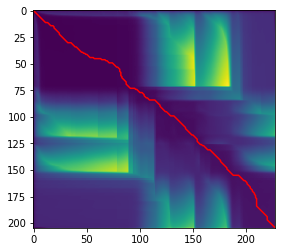

In [241]:
word = 'sanati'
src = get_features(path1 + word + '.wav')
test = get_features(path1 + word + '2.wav')
D, path = DTW(src.T, test.T, dist, lc_type='1', weighted=False)
p,q = path
print('distance:', D[-1,-1], D.shape)
plt.imshow(D)
plt.plot(q,p, c='red')
plt.show()

### making train samples

To have a train sample for each word we find the optimal alignment between source and two other files, then we calculate a mean for each frame corresponding to a specific frame in the source.

In [255]:
def get_mean_sample(word, path, lc_type, weighted=False):
    src = get_features(path + word + '.wav')
    t1 = get_features(path + word + '1.wav')
    t2 = get_features(path + word + '2.wav')
    _, src_t1_path = DTW(src.T, t1.T, lc_type=lc_type, weighted=weighted)
    _, src_t2_path = DTW(src.T, t2.T, lc_type=lc_type, weighted=weighted)
    
    src_len = src.shape[1]
    res = [[] for _ in range(src_len)]
    for i,ind in enumerate(src_t1_path[0]):
        res[ind] += [t1[:,src_t1_path[1][i]]]
    for i,ind in enumerate(src_t2_path[0]):
        res[ind] += [t2[:,src_t2_path[1][i]]]
    for i in range(src_len):
        s = sum(res[i])/ len(res[i])
        res[i] = s
    res = np.array(res).T
    return res

In [256]:
train_samples = {'1': {}, '2':{}}
for k in train_samples:
    for word in words:
        train_samples[k][word] = get_mean_sample(word, path1, k)

In [257]:
for k,v in train_samples.items():
    for w in v:
        print(k, w, v[w].shape)

1 sanati (12, 205)
1 sharif (12, 205)
1 daneshgah (12, 242)
1 computer (12, 221)
2 sanati (12, 205)
2 sharif (12, 205)
2 daneshgah (12, 242)
2 computer (12, 221)


In [258]:
res = {}
for file in tqdm(files2):
    res[file] = {}
    feat = get_features(path2 + file)
    for type, v in train_samples.items():
        res[file][type] = {}
        for word, ref in v.items():
            D, _ = DTW(feat.T, ref.T, lc_type=type)
            res[file][type][word] = D[-1,-1]

  0%|          | 0/12 [00:00<?, ?it/s]

In [259]:
res

{'sharif2.wav': {'1': {'sanati': 24069.8178605318,
   'sharif': 12884.880647745684,
   'daneshgah': 36773.55270269446,
   'computer': 30045.597785442576},
  '2': {'sanati': 28561.29294717471,
   'sharif': 14200.13048700474,
   'daneshgah': 44755.01632729677,
   'computer': 36199.496445712226}},
 'sanati1.wav': {'1': {'sanati': 11358.011186773074,
   'sharif': 16795.366865221455,
   'daneshgah': 28473.924702247354,
   'computer': 24219.425422975924},
  '2': {'sanati': 17722.18573441811,
   'sharif': 26790.52198859749,
   'daneshgah': 49473.516354461965,
   'computer': 49493.48303126137}},
 'sharif1.wav': {'1': {'sanati': 21384.54122692625,
   'sharif': 9575.991181273706,
   'daneshgah': 33243.13591622938,
   'computer': 27893.6445377722},
  '2': {'sanati': 24684.84294191331,
   'sharif': 10341.84303812105,
   'daneshgah': 40756.0607022821,
   'computer': 33418.08630820038}},
 'sanati2.wav': {'1': {'sanati': 28238.588460690255,
   'sharif': 34867.14680009237,
   'daneshgah': 36212.690629

In [268]:
for file in res:
    print('test file:', file)
    for type in res[file]:
        s = 9999999999
        pred = ''
        for k,v in res[file][type].items():
            if v < s:
                s = v
                pred = k
        print('\ttype:', type, 'prediction:', pred)

test file: sharif2.wav
	type: 1 prediction: sharif
	type: 2 prediction: sharif
test file: sanati1.wav
	type: 1 prediction: sanati
	type: 2 prediction: sanati
test file: sharif1.wav
	type: 1 prediction: sharif
	type: 2 prediction: sharif
test file: sanati2.wav
	type: 1 prediction: sanati
	type: 2 prediction: sharif
test file: sanati.wav
	type: 1 prediction: sanati
	type: 2 prediction: sharif
test file: daneshgah.wav
	type: 1 prediction: sanati
	type: 2 prediction: sanati
test file: sharif.wav
	type: 1 prediction: sharif
	type: 2 prediction: sharif
test file: computer.wav
	type: 1 prediction: computer
	type: 2 prediction: computer
test file: computer1.wav
	type: 1 prediction: computer
	type: 2 prediction: computer
test file: daneshgah1.wav
	type: 1 prediction: daneshgah
	type: 2 prediction: sanati
test file: computer2.wav
	type: 1 prediction: computer
	type: 2 prediction: computer
test file: daneshgah2.wav
	type: 1 prediction: daneshgah
	type: 2 prediction: sanati


## Part B

All above with weighting enabled

In [260]:
train_samples_w = {'1': {}, '2':{}}
for k in train_samples_w:
    for word in words:
        train_samples_w[k][word] = get_mean_sample(word, path1, k, weighted=True)

In [261]:
for k,v in train_samples_w.items():
    for w in v:
        print(k, w, v[w].shape)

1 sanati (12, 205)
1 sharif (12, 205)
1 daneshgah (12, 242)
1 computer (12, 221)
2 sanati (12, 205)
2 sharif (12, 205)
2 daneshgah (12, 242)
2 computer (12, 221)


In [262]:
res_w = {}
for file in tqdm(files2):
    res_w[file] = {}
    feat = get_features(path2 + file)
    for type, v in train_samples_w.items():
        res_w[file][type] = {}
        for word, ref in v.items():
            D, _ = DTW(feat.T, ref.T, lc_type=type, weighted=True)
            res_w[file][type][word] = D[-1,-1]

  0%|          | 0/12 [00:00<?, ?it/s]

In [263]:
res_w

{'sharif2.wav': {'1': {'sanati': 29509.559792139997,
   'sharif': 16116.67672882082,
   'daneshgah': 41159.158411570075,
   'computer': 33760.4477015744},
  '2': {'sanati': 14930.427305373614,
   'sharif': 7719.134904653569,
   'daneshgah': 23842.283078906083,
   'computer': 19943.373508782533}},
 'sanati1.wav': {'1': {'sanati': 15173.988673052228,
   'sharif': 22332.910157056314,
   'daneshgah': 33153.038003134934,
   'computer': 31714.711663261343},
  '2': {'sanati': 9083.083453431698,
   'sharif': 14171.7657008002,
   'daneshgah': 25418.504955655473,
   'computer': 25687.236297366468}},
 'sharif1.wav': {'1': {'sanati': 27074.020359106267,
   'sharif': 12432.335744971135,
   'daneshgah': 39401.564671271546,
   'computer': 32786.68156831464},
  '2': {'sanati': 13128.552245419154,
   'sharif': 5859.100112723082,
   'daneshgah': 21135.297838365277,
   'computer': 17520.378779901137}},
 'sanati2.wav': {'1': {'sanati': 32531.35376806971,
   'sharif': 40196.766524499195,
   'daneshgah': 43

In [269]:
for file in res_w:
    print('test file:', file)
    for type in res_w[file]:
        s = 9999999999
        pred = ''
        for k,v in res_w[file][type].items():
            if v < s:
                s = v
                pred = k
        print('\ttype:', type, 'prediction:', pred)

test file: sharif2.wav
	type: 1 prediction: sharif
	type: 2 prediction: sharif
test file: sanati1.wav
	type: 1 prediction: sanati
	type: 2 prediction: sanati
test file: sharif1.wav
	type: 1 prediction: sharif
	type: 2 prediction: sharif
test file: sanati2.wav
	type: 1 prediction: sanati
	type: 2 prediction: sharif
test file: sanati.wav
	type: 1 prediction: sanati
	type: 2 prediction: sharif
test file: daneshgah.wav
	type: 1 prediction: sanati
	type: 2 prediction: sanati
test file: sharif.wav
	type: 1 prediction: sharif
	type: 2 prediction: sharif
test file: computer.wav
	type: 1 prediction: computer
	type: 2 prediction: computer
test file: computer1.wav
	type: 1 prediction: computer
	type: 2 prediction: computer
test file: daneshgah1.wav
	type: 1 prediction: daneshgah
	type: 2 prediction: sanati
test file: computer2.wav
	type: 1 prediction: computer
	type: 2 prediction: computer
test file: daneshgah2.wav
	type: 1 prediction: sanati
	type: 2 prediction: sanati


## Part C
Energy

In [270]:
def get_energy(sample):
    res = []
    for f in sample:
        res += [np.sum(np.square(f))]
    return np.array(res)